# Classifieur Adaboost
AdaBoost est un modèle d'ensemble qui améliore la performance en séquence en accordant plus de poids aux exemples mal classés. Il combine des classificateurs faibles, comme des arbres de décision peu profonds, pour former un modèle global robuste adapté à la classification.

In [21]:
import DataManagement as DM
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import AdaBoostClassifier,RandomForestClassifier,ExtraTreesClassifier,BaggingClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

dataset = DM.Dataset('data/train.csv')
dataset.split_data(test_size=0.3, seed=0, stratified=True)
dataset.info()


(693, 192) (297, 192)
##### Informations #####
  - Nb classes   : 99 ( Dim : 192 )
  - Nb samples   : 990
     - Training  : 693 ( 70.0 % )
     - Test      : 297 ( 30.0 % )
########################


Puisque qu'on a beaucoup de classe et très peu de données par classe, on a séparé notre ensemble de données de façon à avoir autant de données dans chaque classe.

## Entrainement

Pour notre classifieur Adaboost, nous utilisons deux hyperparamètres clés :

- base_estimator: c'est le faible 'learner' utilisé pour entrainer le réseau. le DecisionTreeClassifier est utilisé en tant que faible learner par défaut.
- Le nombre d'estimateurs : qui indique le nombre de faible 'learners' à entrainer.
- Le learning rate : qui contribue au poids des faibles 'learners'. la valeur par défaut utilisée est 1.

Bien que le nombre d'estimateur soit souvent l'hyperparamètre le plus crucial, l'impact des autres hyperparamètres sur les performances du modèle sera étudié.

### Recherche des hyperparamètres

On utilise une validation croisée à 5 plis. On utilise un nombre de plis assez petit parce qu'on a très peu de données par classe (seulement 7) et on veut éviter d'avoir des plis qui n'ont pas de données pour certaines classes.

In [26]:

hyperparameters_dt = {
        # Hyperparamètres AdaBoostClassifier
        'n_estimators': range(60, 101, 10),
        'learning_rate': [0.01, 0.1, 1.0],
        'base_estimator': [RandomForestClassifier(), ExtraTreesClassifier(),SVC(probability=True, kernel='linear')],
    }

grid, results = DM.train_model(AdaBoostClassifier(), hyperparameters_dt, dataset)
print('Best:', grid.best_params_, 'with score {:.3}'.format(grid.best_score_))


Fitting 5 folds for each of 45 candidates, totalling 225 fits


Best: {'base_estimator': ExtraTreesClassifier(), 'learning_rate': 0.1, 'n_estimators': 100} with score 0.973


### Analyse de l'entrainement

Le nombre optimal d'estimateurs (n_estimators) est de 100, ce qui suggère que le modèle Adaboost utilise un ensemble significatif d'estimateurs pour réaliser des prédictions précises sur les espèces de feuilles. En analysant les performances du modèle à ce nombre spécifique d'estimateurs, nous pouvons évaluer l'impact des autres hyperparamètres sur ces résultats.

In [31]:
results[results.param_n_estimators == grid.best_params_['n_estimators']].sort_values(by='rank_test_score')

,param_n_estimators,param_learning_rate,param_base_estimator,mean_test_score,rank_test_score
24,100,0.1,ExtraTreesClassifier(),0.972610,1
14,100,1.0,RandomForestClassifier(),0.971160,5
19,100,0.01,ExtraTreesClassifier(),0.971160,5
29,100,1.0,ExtraTreesClassifier(),0.968251,18
9,100,0.1,RandomForestClassifier(),0.966854,19
4,100,0.01,RandomForestClassifier(),0.965384,25
39,100,0.1,"SVC(kernel='linear', probability=True)",0.512282,33
44,100,1.0,"SVC(kernel='linear', probability=True)",0.427098,36
34,100,0.01,"SVC(kernel='linear', probability=True)",0.150078,41


On remarque que le type de classifieur faible influence grandement la précision. En effet, les classifieurs ExtraTree ont de meilleures performance que le randomForest même si ces dernières reste performantes. Par contre le SVC a de loin les pires performances du lot.

Concernant le learning rate, ses valeurs optimales semble dépendre du type de classifieur faible qui préféreraient soit un plus petit soit un plus grand learning rate. 

On peut tracer un graphique du score en fonction des différentes valeurs d'hyperparamètres pour réellement voir l'impact de leur variation sur le score.

In [173]:
rdf = results['param_base_estimator'].unique()[0]
# print(results.query(f'param_learning_rate == 0.1 and param_base_estimator == "{rdf}"'))
# print(rdf)

grouped = results.groupby('param_base_estimator')
df_grouped = grouped.get_group(f'{rdf}')
 
print(df_grouped)

# pour la conclusion faire un tableau avec score precision et jsp quoi afin de choisir le meilleur

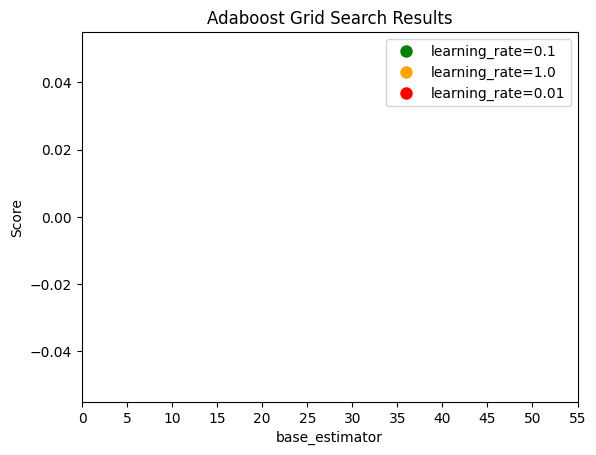

In [120]:
plt.scatter(results.query('param_learning_rate == 0.1 and param_n_estimators == "ExtraTreesClassifier()"')['param_n_estimators'],
            results.query('param_learning_rate == 0.1 and param_base_estimator == "ExtraTreesClassifier()"')['mean_test_score'],
            marker='o', color='green', label='learning_rate=0.1, base_estimator=ExtraTreesClassifier()')
plt.scatter(results.query('param_learning_rate == 1.0 and param_base_estimator == "ExtraTreesClassifier()"')['param_n_estimators'],
            results.query('param_learning_rate == 1.0 and param_base_estimator == "ExtraTreesClassifier()"')['mean_test_score'],
            marker='o', color='orange', label='learning_rate=1.0, base_estimator=ExtraTreesClassifier()')
plt.scatter(results.query('param_learning_rate == 0.01 and param_base_estimator == "ExtraTreesClassifier()"')['param_n_estimators'],
            results.query('param_learning_rate == 0.01 and param_base_estimator == "ExtraTreesClassifier()"')['mean_test_score'],
            marker='o', color='red', label='learning_rate=0.01, base_estimator=ExtraTreesClassifier')

plt.xlabel("base_estimator")
plt.ylabel("Score")
plt.title("Adaboost Grid Search Results")
plt.xticks(np.arange(0, 60, 5))  # Graduations de 1 en 1 sur l'abscisse
legend = [
    plt.Line2D([0], [0], marker='o', color='white', markerfacecolor='green', markersize=10, label='learning_rate=0.1'),
    plt.Line2D([0], [0], marker='o', color='white', markerfacecolor='orange', markersize=10, label='learning_rate=1.0'),
    plt.Line2D([0], [0], marker='o', color='white', markerfacecolor='red', markersize=10, label='learning_rate=0.01')
    ]
plt.legend(handles=legend)

plt.show()



# plt.xlabel("base_estimator")
# plt.ylabel("Score")
# plt.title("Decision Tree Grid Search Results")
# plt.xticks(np.arange(0, 60, 5))  # Graduations de 1 en 1 sur l'abscisse
# legend = [
#     plt.Line2D([0], [0], marker='s', color='white', markerfacecolor='black', markersize=10, label='gini'), 
#     plt.Line2D([0], [0], marker='o', color='white', markerfacecolor='black', markersize=10, label='entropy'), 
#     plt.Line2D([0], [0], marker='^', color='white', markerfacecolor='black', markersize=10, label='log_loss'),
#     plt.Line2D([0], [0], color='blue', linewidth=5, label='random'),
#     plt.Line2D([0], [0], color='red', linewidth=5, label='best')
#     ]
# plt.legend(handles=legend, ncols=2)

# plt.show()
plt.show()


Nous observons que le choix du critère de séparation n'a pas un impact significatif sur les performances du modèle. En effet, les scores moyens obtenus pour les critères "gini", "entropy", et "log_loss" ne présentent pas de différences notables. Cependant, on observe que le critère "gini" tend à obtenir de légèrement meilleures performances en moyenne.

Par ailleurs, en ce qui concerne le choix du séparateur, il semble que le séparateur "best" soit en moyenne plus performant que le séparateur "random". Les résultats montrent que, quel que soit le critère utilisé, le splitter "best" obtient généralement des scores moyens supérieurs. Bien que la différence ne soit pas toujours très significative, cette tendance suggère que le processus de sélection "best" qui évalue toutes les divisions possibles conduit à de meilleures performances que le choix aléatoire de la division "random".

## Évaluation

On évalue le meilleur modèle entrainé à l'aide de notre ensemble de test. Pour l'évaluation, on regarde les métriques suivantes:
- La précision ("precision") : la proportion de données appartenant réellement à leur classe prédite
- Le rappel ("recall") : la proportion des données bien classées (la justesse des prédictions pour une classe)
- Le f1-score : la moyenne harmonique de la précision et du rappel

Comme nous sommes dans une situation de classification multi-classe, on calcule ces métriques individuellement pour chaque classe. On peut ensuite regarder la distribution des résultats pour évaluer notre modèle.

### Averages ###
   - precision : 98.333% ± 6.739%
   - recall    : 97.643% ± 9.820%
   - f1_score  : 97.511% ± 7.513%
################


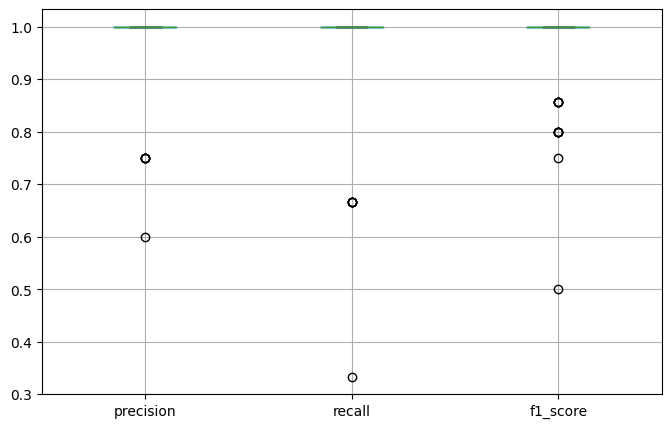

In [137]:
test_preds = grid.predict(dataset.x_test)
test_reports = DM.evaluate_predictions(dataset.t_test, test_preds, dataset.classes)

Étant donné le nombre élevé de classes (99), l'évaluation des performances pour chaque classe individuelle peut rapidement devenir impraticable. Pour obtenir une vue d'ensemble, nous analysons plutôt la moyenne des métriques à travers l'ensemble des classes. Globalement, notre modèle démontre une performance robuste, manifestant à la fois une précision et une justesse élevées.

Cependant, l'examen des boxplots révèle que les prédictions ne sont pas parfaites pour la grande majorité des classes. Les boxplots affichent une dispersion significative, caractérisée par des médianes ne dépassant pas 0.7 et des quartiles ainsi que des extrémités de moustaches relativement faibles.

Comme on peut le voir dans le boxplot, les prédictions sont parfaites (métriques à 1.0) pour la grande majorité des classes. Il y a cependant des classes pour lesquelles le modèle a moins bien performé (12 classes). Regardons de quelles classes il s'agit.

In [138]:
bad_classes = test_reports.query('precision < 1.0 or recall < 1.0')
print(bad_classes)
print('Sum:', len(bad_classes))

                         precision    recall  f1_score
Betula_Pendula                0.60  1.000000  0.750000
Ilex_Cornuta                  0.75  1.000000  0.857143
Liriodendron_Tulipifera       1.00  0.666667  0.800000
Quercus_Agrifolia             0.75  1.000000  0.857143
Quercus_Canariensis           0.75  1.000000  0.857143
Quercus_Castaneifolia         1.00  0.666667  0.800000
Quercus_Palustris             0.75  1.000000  0.857143
Quercus_Phillyraeoides        1.00  0.666667  0.800000
Quercus_Pontica               1.00  0.666667  0.800000
Quercus_Shumardii             1.00  0.666667  0.800000
Sorbus_Aria                   1.00  0.333333  0.500000
Tilia_Oliveri                 0.75  1.000000  0.857143
Sum: 12


Pour évaluer les performances de notre modèle Adaboost, nous pouvons également utiliser une matrice de confusion pour visualiser les prédictions incorrectes sur l'ensemble de test. La matrice de confusion affiche les classifications réelles par rapport aux classifications prédites, permettant ainsi d'identifier les erreurs et les tendances de notre modèle.

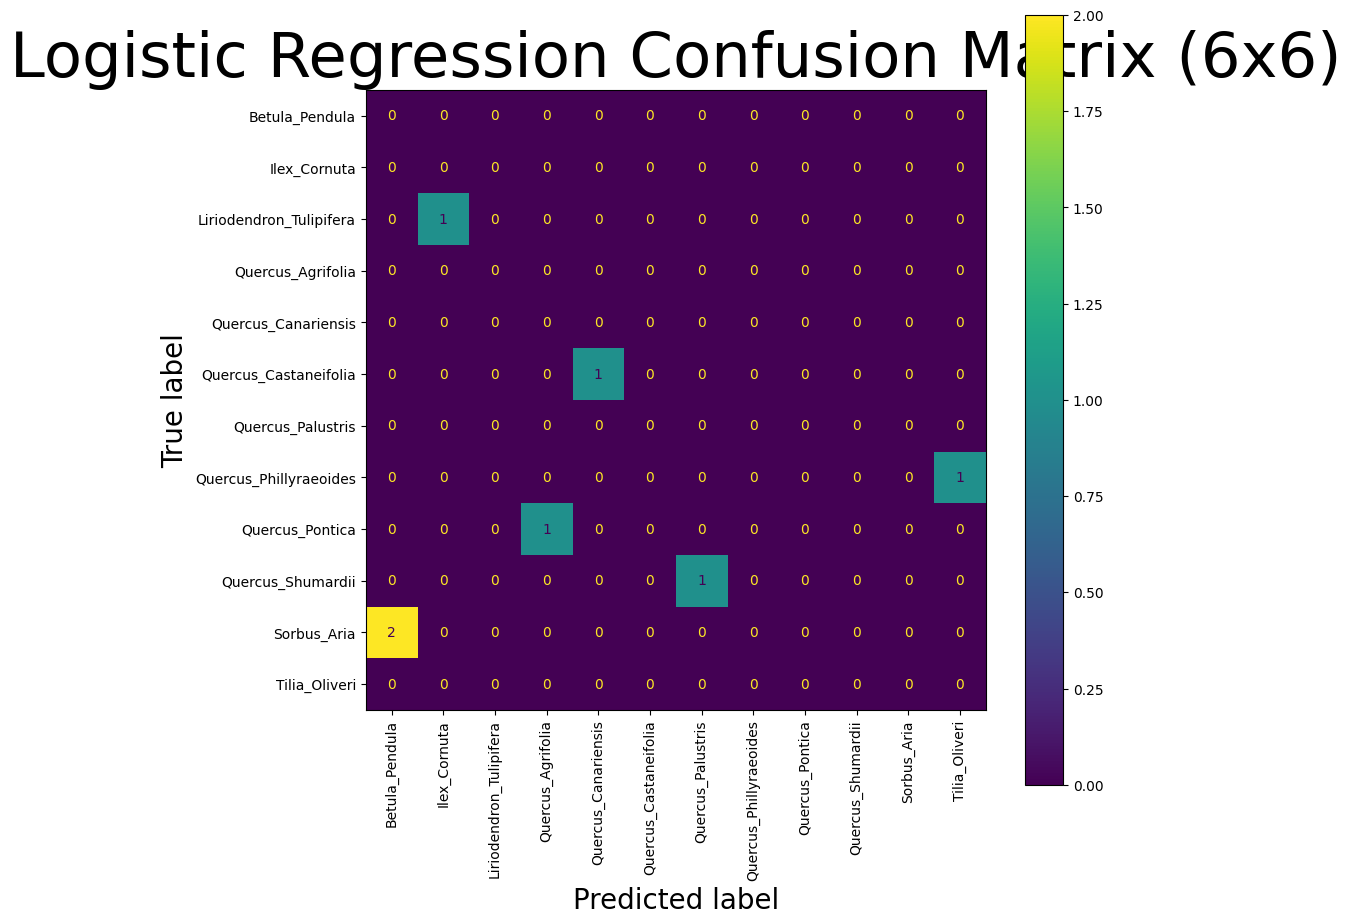

In [151]:
from sklearn.metrics import ConfusionMatrixDisplay

# Get all the wrong predictions
bad_preds = DM.extract_bad_predictions(dataset.t_test, test_preds, labels=dataset.classes, ids=dataset.id_test)
matrix_size = len(bad_preds['True Class'].unique())

# Display them as a confusion matrix
display = ConfusionMatrixDisplay.from_predictions(bad_preds['True Class'], bad_preds['Predicted Class'], 
                                                  labels=bad_classes.index, xticks_rotation='vertical')
display.figure_.set_figwidth(10)
display.figure_.set_figheight(10)

# Ajustez la taille de la police des titres des axes
display.ax_.set_title(f'Logistic Regression Confusion Matrix ({matrix_size}x{matrix_size})', fontsize=45)
display.ax_.xaxis.label.set_size(20)  # Ajustez la taille de la police pour l'axe des x
display.ax_.yaxis.label.set_size(20)  # Ajustez la taille de la police pour l'axe des y

plt.show()


Aucun schéma ou relation spécifique n'émerge clairement parmi les prédictions erronées. Il est donc probable que ces erreurs soient associées à des données où les caractéristiques sont moins nettement définies.

### Conclusion

Les paramètres optimaux pour notre modèle Adaboost un nombre d'estimateur assez grands,qui préférablement soient des arbres de décision, et un learning rate modeste. Avec ces hyperparamètres, le modèle performe extrêmement bien, avec des valeurs entre 97 et 98% pour les différentes métriques de performance, et ne semble donc ni sous-apprendre ni sur-apprendre.


Cependant, il est important de souligner que notre ensemble de données comporte un grand nombre de classes (99) et un nombre relativement faible de données par classe (seulement 10). De plus, notre ensemble de test ne comptait que 3 données par classe, ce qui est une quantité très limitée. Par conséquent, il est complexe d'affirmer si les résultats obtenus reflètent fidèlement les performances réelles du modèle.